###### Written by: Sam Johnson and Mohammad Shafkat Islam
###### Date: November 7, 2018
###### Purpose: Segmentation of Optic Disc from Color Fundus Photographs using U-Net
###### Course Project: Deep Learning

In [1]:
# Import necessary stuff and Show the Image and Label Directory:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers.core import Dropout, Lambda
from tensorflow.python.keras.layers.convolutional import Conv2D, Conv2DTranspose
from tensorflow.python.keras.layers.pooling import MaxPooling2D
from tensorflow.python.keras.layers.merge import concatenate
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 3
TRAIN_PATH = '/local/vol00/scratch/Shafkat/Projects/P0002_C_Optic_Disc_Segmentation/Data/Clean/'
TEST_PATH = '/local/vol00/scratch/Shafkat/Projects/P0002_C_Optic_Disc_Segmentation/Data/Clean/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed


In [2]:
# Find all the training image and Labels
from glob import glob
fundus_files = glob(TRAIN_PATH + "/Images/*.jpg")
#print fundus_files[0]
mask_files = glob(TRAIN_PATH + "/Label/*.bmp")

In [3]:
filelist = []
for root, dirs, files in os.walk('/local/vol00/scratch/Shafkat/Projects/P0002_C_Optic_Disc_Segmentation/Data/Clean/Images'):
    #print files
    filelist = filelist + [os.path.join(x) for x in files if x.endswith(('.jpg'))]  
print filelist    

['n0001.jpg', 'n0002.jpg', 'n0003.jpg', 'n0004.jpg', 'n0005.jpg', 'n0006.jpg', 'n0007.jpg', 'n0008.jpg', 'n0009.jpg', 'n0010.jpg', 'n0011.jpg', 'n0012.jpg', 'n0013.jpg', 'n0014.jpg', 'n0015.jpg', 'n0016.jpg', 'n0017.jpg', 'n0018.jpg', 'n0019.jpg', 'n0020.jpg', 'n0021.jpg', 'n0022.jpg', 'n0023.jpg', 'n0024.jpg', 'n0025.jpg', 'n0026.jpg', 'n0027.jpg', 'n0028.jpg', 'n0029.jpg', 'n0030.jpg', 'n0031.jpg', 'n0032.jpg', 'n0033.jpg', 'n0034.jpg', 'n0035.jpg', 'n0036.jpg', 'n0037.jpg', 'n0038.jpg', 'n0039.jpg', 'n0040.jpg', 'n0041.jpg', 'n0042.jpg', 'n0043.jpg', 'n0044.jpg', 'n0045.jpg', 'n0046.jpg', 'n0047.jpg', 'n0048.jpg', 'n0049.jpg', 'n0050.jpg', 'n0051.jpg', 'n0052.jpg', 'n0053.jpg', 'n0054.jpg', 'n0055.jpg', 'n0056.jpg', 'n0057.jpg', 'n0058.jpg', 'n0059.jpg', 'n0060.jpg', 'n0061.jpg', 'n0062.jpg', 'n0063.jpg', 'n0064.jpg', 'n0065.jpg', 'n0066.jpg', 'n0067.jpg', 'n0068.jpg', 'n0069.jpg', 'n0070.jpg', 'n0071.jpg', 'n0072.jpg', 'n0073.jpg', 'n0074.jpg', 'n0075.jpg', 'n0076.jpg', 'n0077.jpg'

In [5]:
# Randomize the list order to have glaucoma and non glaucoma mixed.
from random import shuffle
new_filelist_random = filelist[:] #
shuffle(new_filelist_random) 
print(new_filelist_random)


['n0146.jpg', 'n0046.jpg', 'n0360.jpg', 'n0268.jpg', 'n0133.jpg', 'n0048.jpg', 'n0272.jpg', 'n0198.jpg', 'n0018.jpg', 'n0159.jpg', 'n0224.jpg', 'n0197.jpg', 'n0257.jpg', 'n0229.jpg', 'n0031.jpg', 'n0255.jpg', 'n0189.jpg', 'n0342.jpg', 'n0252.jpg', 'g0016.jpg', 'n0150.jpg', 'g0001.jpg', 'n0352.jpg', 'n0060.jpg', 'n0347.jpg', 'n0115.jpg', 'n0228.jpg', 'n0028.jpg', 'n0205.jpg', 'g0027.jpg', 'n0332.jpg', 'n0141.jpg', 'n0142.jpg', 'n0109.jpg', 'n0184.jpg', 'n0234.jpg', 'g0004.jpg', 'n0306.jpg', 'n0171.jpg', 'n0160.jpg', 'n0047.jpg', 'n0064.jpg', 'g0029.jpg', 'n0116.jpg', 'n0335.jpg', 'n0062.jpg', 'n0049.jpg', 'n0051.jpg', 'n0356.jpg', 'g0025.jpg', 'n0136.jpg', 'n0358.jpg', 'n0132.jpg', 'n0242.jpg', 'n0296.jpg', 'n0319.jpg', 'n0346.jpg', 'n0221.jpg', 'g0014.jpg', 'n0309.jpg', 'n0235.jpg', 'n0037.jpg', 'n0087.jpg', 'n0351.jpg', 'n0022.jpg', 'n0086.jpg', 'n0043.jpg', 'n0155.jpg', 'n0009.jpg', 'n0323.jpg', 'n0105.jpg', 'n0298.jpg', 'n0254.jpg', 'n0058.jpg', 'g0032.jpg', 'n0207.jpg', 'g0017.jpg'

In [4]:
# # Get train and test IDs
# train_ids = next(os.walk(TRAIN_PATH))
# print train_ids
# #test_ids = next(os.walk(TEST_PATH))[1]

In [6]:
# Get and resize train images and masks
X_train = np.zeros((len(new_filelist_random), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(new_filelist_random), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(new_filelist_random ), total=len(new_filelist_random )):
    #print n, id_
    img = imread(TRAIN_PATH + '/Images/' + id_)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_ = imread(TRAIN_PATH + '/Labels/' + id_[:-4] + '.bmp')
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
    #mask = np.maximum(mask, mask_)
    #mask = np.invert(mask_) 
    binary = mask_==255
    Y_train[n] = mask_
    Y_train[n] = np.invert(binary)

Getting and resizing train images and masks ... 


100%|██████████| 400/400 [01:36<00:00,  4.30it/s]


(512, 512, 1)


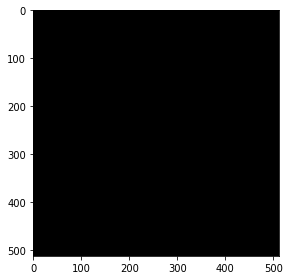

[[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]]
[[[255.]
  [255.]
  [255.]
  ...
  [255.]
  [255.]
  [255.]]

 [[255.]
  [255.]
  [255.]
  ...
  [255.]
  [255.]
  [255.]]

 [[255.]
  [255.]
  [255.]
  ...
  [255.]
  [255.]
  [255.]]

 ...

 [[255.]
  [255.]
  [255.]
  ...
  [255.]
  [255.]
  [255.]]

 [[255.]
  [255.]
  [255.]
  ...
  [255.]
  [255.]
  [255.]]

 [[255.]
  [255.]
  [255.]
  ...
  [255.]
  [255.]
  [255.]]]
[[[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 [[False]
  [False]
  [False]
  ...
  [False]
  [False]
  [False]]

 ...

In [7]:
print mask.shape
imshow(np.squeeze(mask, axis = 2))
#print Y_train[0].dtype, Y_train[0]
plt.show()
print mask
print mask_
print Y_train[0]

In [8]:
# imshow(np.squeeze(Y_train[int(Y_train[399])]))
# #print Y_train[0].dtype, Y_train[0]
# plt.show()

TypeError: only size-1 arrays can be converted to Python scalars

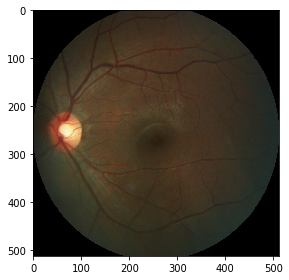

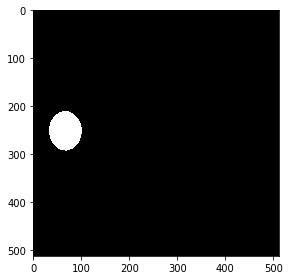

In [9]:
# Check if training data looks all right
ix = random.randint(0, len(filelist))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]), cmap = 'Greys_r')
plt.show()

In [10]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [11]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou,'binary_accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 512, 512, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (

In [12]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('/local/vol00/scratch/Shafkat/Projects/P0002_C_Optic_Disc_Segmentation/from_Tensorflow/sample_od_segmentation_checkpoint/whole_OD_working_512_random_order.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=10, 
                    callbacks=[earlystopper, checkpointer])

Train on 360 samples, validate on 40 samples
Epoch 1/10
352/360 [============================>.] - ETA: 9s - loss: 3.2623 - mean_iou: 0.4602 - binary_accuracy: 0.9390 
Epoch 00001: val_loss improved from inf to 1.59343, saving model to /local/vol00/scratch/Shafkat/Projects/P0002_C_Optic_Disc_Segmentation/from_Tensorflow/sample_od_segmentation_checkpoint/whole_OD_working_512_random_order.h5
360/360 [==============================] - 460s 1s/step - loss: 3.2049 - mean_iou: 0.4611 - binary_accuracy: 0.9399 - val_loss: 1.5934 - val_mean_iou: 0.4977 - val_binary_accuracy: 0.9836
Epoch 2/10
352/360 [============================>.] - ETA: 9s - loss: 1.3385 - mean_iou: 0.4967 - binary_accuracy: 0.9828 
Epoch 00002: val_loss improved from 1.59343 to 0.88990, saving model to /local/vol00/scratch/Shafkat/Projects/P0002_C_Optic_Disc_Segmentation/from_Tensorflow/sample_od_segmentation_checkpoint/whole_OD_working_512_random_order.h5
360/360 [==============================] - 455s 1s/step - loss: 1.3

In [13]:
# Predict on train, val and test
X_test = X_train
model = load_model('/local/vol00/scratch/Shafkat/Projects/P0002_C_Optic_Disc_Segmentation/from_Tensorflow/sample_od_segmentation_checkpoint/whole_OD_working_512_random_order.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (IMG_HEIGHT, IMG_WIDTH), 
                                       mode='constant', preserve_range=True))

400/400 [==============================] - 156s 391ms/step


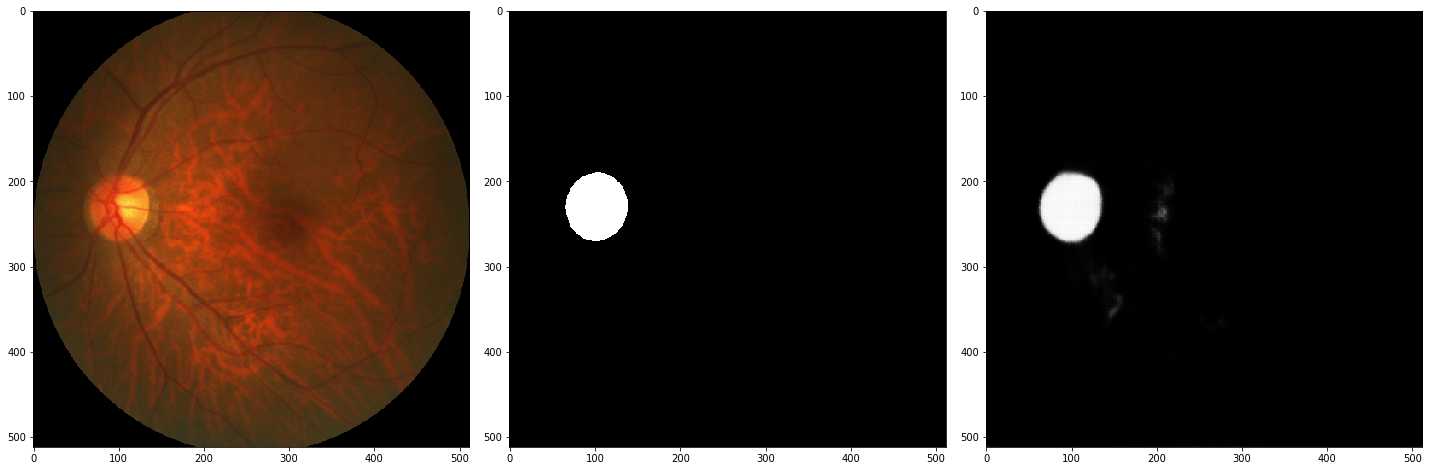

In [19]:
# Perform a sanity check on some random training samples
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
ix = random.randint(0, len(preds_train_t))
plt.subplot(1, 3, 1)
imshow(X_train[ix])
#plt.show()
plt.subplot(1, 3, 2)
imshow(np.squeeze(Y_train[ix]),cmap = 'Greys_r')
#plt.show()
plt.subplot(1, 3, 3)
imshow(np.squeeze(preds_train[ix]),cmap = 'Greys_r')
plt.show()


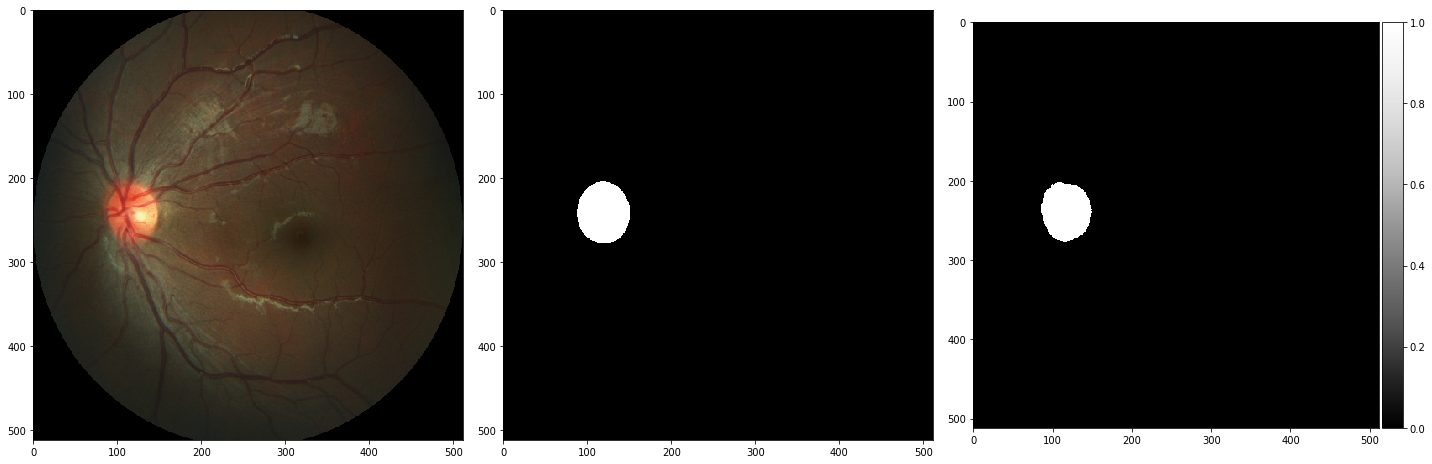

In [21]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
plt.subplot(1, 3, 1)
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.subplot(1, 3, 2)
#plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]),cmap = 'Greys_r')
#plt.show()
plt.subplot(1, 3, 3)
imshow(np.squeeze(preds_val_t[ix]),cmap = 'Greys_r')
plt.show()

In [4]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [05:11<00:00,  4.36it/s]


### Here is our Fancy U-Net

In [5]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D, UpSampling2D, concatenate, merge

def unet(pretrained_weights = None,input_size = (512,512,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6],axis=3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)
    #model = tf.keras.models.Sequential()
    #model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model
unet()

In [6]:
# Save the Checkpoint Directory
checkpoint_path = "/local/vol00/scratch/Shafkat/Projects/P0002_C_Optic_Disc_Segmentation/from_Tensorflow/checkpoints_sample/cp-sample-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True, period=1)
# Check for Latest Checkpoints:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

u'/local/vol00/scratch/Shafkat/Projects/P0002_C_Optic_Disc_Segmentation/from_Tensorflow/checkpoints_sample/cp-sample-0010.ckpt'

In [7]:
# To load a latest checkpoints:
# To test, reset the model and load the latest checkpoint:

# model = create_model()
# model.load_weights(latest)
# loss, acc = model.evaluate(test_images, test_labels)
# print("Restored model, accuracy: {:5.2f}%".format(100*acc))


In [8]:
## Start Training on the Network:
model = unet()
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])
#
#model.fit(X_train, Y_train, epochs=10, batch_size=16, callbacks = [cp_callback]) 
#score = model.evaluate(x_train, new_y_train, batch_size=12)

Epoch 1/10
656/670 [============================>.] - ETA: 2:49 - loss: 11.7657 - acc: 0.8480
Epoch 00001: saving model to /local/vol00/scratch/Shafkat/Projects/P0002_C_Optic_Disc_Segmentation/from_Tensorflow/checkpoints_sample/cp-sample-0001.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
670/670 [==============================] - 8130s 12s/step - loss: 11.7205 - acc: 0.8471
Epoch 2/10
656/670 [============================>.] - ETA: 2:49 - loss: 10.8041 - acc: 0.8472
Epoch 00002: saving model to /local/vol00/scratch/Shafkat/Projects/P0002_C_Optic_Disc_Segmentation/from_Tensorflow/checkpoints_sample/cp-sample-0002.ckpt

Consider using a TensorFlow optimizer from `tf.train`.
670/670 [==============================] - 8093s 12s/step - loss: 10.7742 - acc: 0.8471
Epoch 3/10
656/670 [============================>.] - ETA: 2:49 - loss: 10.5863 - acc: 0.8480
Epoch 00003: saving model to /local/vol00/scratch/Shafkat/Projects/P0002_C_Optic_Disc_Segmentation/from_Tensorflow/checkpo

In [23]:
model = unet()
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.load_weights(latest)
subset = X_train[0:10]
preds_train = model.predict(subset[:int(subset.shape[0]*0.9)], verbose=1)

print preds_train[0]
# Threshold predictions
preds_train_t = (preds_train > 0.2).astype(np.uint8)
print preds_train[0]


9/9 [==============================] - 25s 3s/step
[[[0.40408826]
  [0.40408826]
  [0.40408826]
  ...
  [0.40408826]
  [0.40408826]
  [0.40408826]]

 [[0.40408826]
  [0.40408826]
  [0.40408826]
  ...
  [0.40408826]
  [0.40408826]
  [0.40408826]]

 [[0.40408826]
  [0.40408826]
  [0.40408826]
  ...
  [0.40408826]
  [0.40408826]
  [0.40408826]]

 ...

 [[0.40408826]
  [0.40408826]
  [0.40408826]
  ...
  [0.40408826]
  [0.40408826]
  [0.40408826]]

 [[0.40408826]
  [0.40408826]
  [0.40408826]
  ...
  [0.40408826]
  [0.40408826]
  [0.        ]]

 [[0.40408826]
  [0.40408826]
  [0.40408826]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]]


In [26]:
print preds_train_t[3]

[[[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 ...

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [1]]

 [[1]
  [1]
  [1]
  ...
  [1]
  [1]
  [0]]

 [[1]
  [1]
  [1]
  ...
  [0]
  [0]
  [0]]]


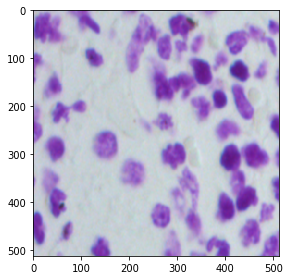

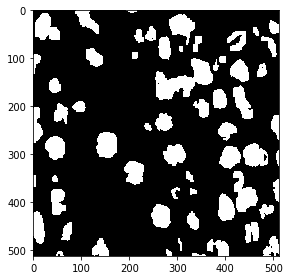

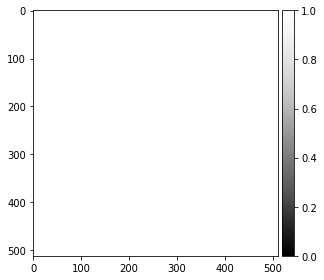

In [24]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[3])
plt.show()
imshow(np.squeeze(Y_train[3]))
plt.show()
imshow(np.squeeze(preds_train_t[3]), cmap = 'Greys_r')
plt.show()

(512, 512, 3)


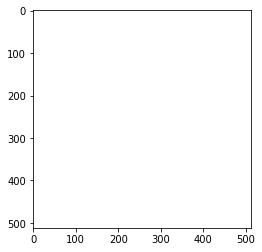

(1, 512, 512, 1)


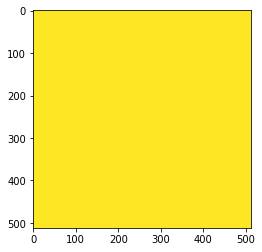

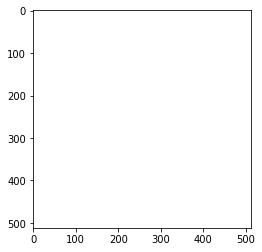

(1, 512, 512, 1)


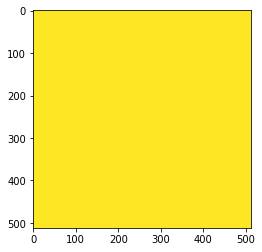

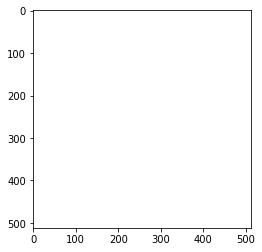

(1, 512, 512, 1)


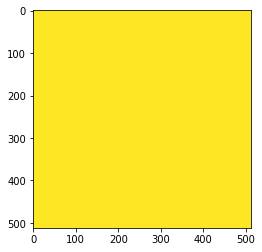

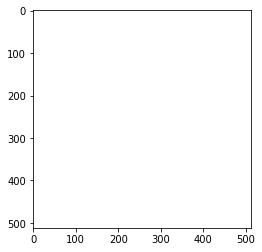

(1, 512, 512, 1)


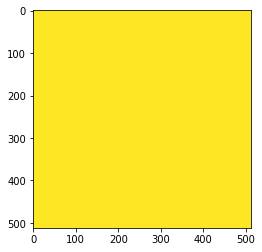

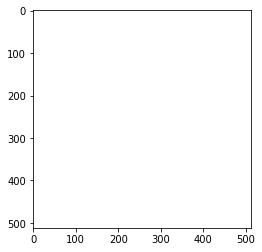

(1, 512, 512, 1)


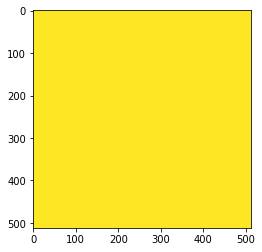

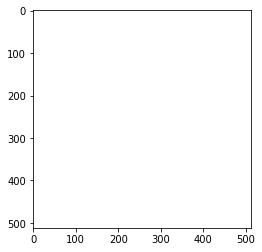

(1, 512, 512, 1)


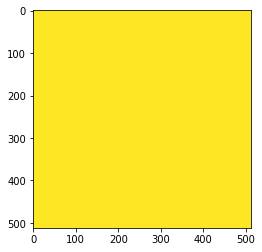

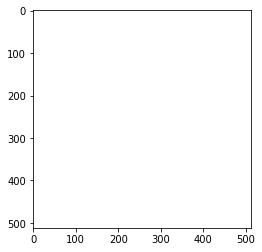

(1, 512, 512, 1)


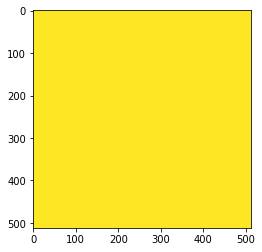

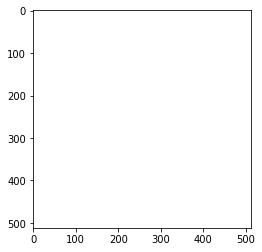

(1, 512, 512, 1)


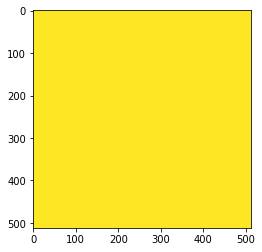

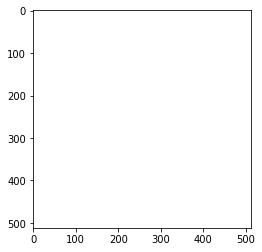

(1, 512, 512, 1)


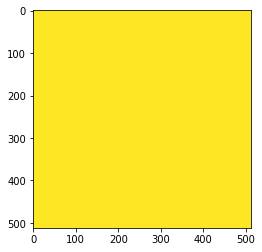

In [15]:
# Test and Visualize the Results of Prediction

model = unet()
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-3), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.load_weights(latest)
print X_train[0].shape
#loss, acc = model.evaluate(x_validation[0], y_validation[0])
for index in range (1,10):
    current_test_image = np.expand_dims(X_train[index], axis=0).astype(np.float32)
    #print current_test_image.shape
    #show_image = np.squeeze(current_test_image, axis=0)
    #show_image = np.squeeze(show_image, axis=2)
    #print show_image.shape
    plt.imshow(show_image, cmap='Greys_r')
    plt.show()
    results = model.predict(current_test_image)
    print results.shape
    new_result = np.squeeze(results, axis=0)
    new_result = np.squeeze(new_result, axis=2)
    #print new_result
    plt.imshow(new_result)
    plt.show()
#saveResult("/local/vol00/scratch/Shafkat/Projects/P0002_C_Optic_Disc_Segmentation/from_Tensorflow/results",results)
# print("Restored model, accuracy: {:5.2f}%".format(100*acc))

In [ ]:
results = model.predict_generator(testGene,30,verbose=1)
saveResult("data/membrane/test",results)


## Future Work:

In [12]:
## Data Normalization:
overall_max = 0
overall_min = 0

# scroll through all images to get max and min across all images
for image in images:
    if ndimage.maximum(image) > overall_max:
        overall_max = ndimage.maximum(image)
    if ndimage.minimum(image) < overall_min:
        overall_min = ndimage.minimum(image)

# For each images in the dataset, normalize it using the above found max and mins 
# We will also augment each image by flipping it left/right so we double our datasize
normalized_images = []
flipped_images = []
for image in images:
    # normalize the image
    normalized_image = image - overall_min
    normalized_image = normalized_image / overall_max
    # add to list of normalized images
    normalized_images.append(normalized_image)
    # add augmented normalized image to separate list
    flipped_images.append(np.fliplr(normalized_image))
    
all_images = normalized_images + flipped_images
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(normalized_images[9])
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(images[9])
print(ndimage.maximum(images[11]))
print(ndimage.maximum(normalized_images[11]))
print(len(all_images))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 512, 512, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 512, 512, 64) 36928       conv2d_24[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 256, 256, 64) 0           conv2d_25[0][0]                  
__________________________________________________________________________________________________
conv2d_26 

In [57]:
# Data Augmentation:

def image_augmentation(image, mask):
    """Returns (maybe) augmented images
    (1) Random flip (left <--> right)
    (2) Random flip (up <--> down)
    (3) Random brightness
    (4) Random hue
    Args:
        image (3-D Tensor): Image tensor of (H, W, C)
        mask (3-D Tensor): Mask image tensor of (H, W, 1)
    Returns:
        image: Maybe augmented image (same shape as input `image`)
        mask: Maybe augmented mask (same shape as input `mask`)
    """
    concat_image = tf.concat([image, mask], axis=-1)

    maybe_flipped = tf.image.random_flip_left_right(concat_image)
    maybe_flipped = tf.image.random_flip_up_down(concat_image)

    image = maybe_flipped[:, :, :-1]
    mask = maybe_flipped[:, :, -1:]

    image = tf.image.random_brightness(image, 0.7)
    image = tf.image.random_hue(image, 0.3)

    return image, mask

In [ ]:
## Toy Network for Practice:

# import tensorflow as tf
# tf.reset_default_graph() # Clear graph before to add things.
# model = tf.keras.models.Sequential()

# #model.add(tf.keras.layers.Input((512,512,3)))
# conv1_1 = model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding = 'same', input_shape=(512,512,3)))
# conv1_2 = model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding = 'same'))(conv1_1)
# pool1 = model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
# conv2_1 = model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding = 'same'))
# conv2_2 = model.add(tf.keras.layers.Conv2D(128, kernel_size=(3,3), activation='relu', padding = 'same'))
# pool2 = model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
# conv3_1 = model.add(tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu', padding = 'same'))
# conv3_2 = model.add(tf.keras.layers.Conv2D(256, kernel_size=(3,3), activation='relu', padding = 'same'))
# pool3 = model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
# conv4_1 = model.add(tf.keras.layers.Conv2D(512, kernel_size=(3,3), activation='relu', padding = 'same'))
# conv4_2 = model.add(tf.keras.layers.Conv2D(512, kernel_size=(3,3), activation='relu', padding = 'same'))
# pool4 = model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
# conv5_1 = model.add(tf.keras.layers.Conv2D(1024, kernel_size=(3,3), activation='relu', padding = 'same'))
# conv5_2 = model.add(tf.keras.layers.Conv2D(1024, kernel_size=(3,3), activation='relu', padding = 'same'))
# pool5 = model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

# """
# model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.Dense(256, activation='relu'))
# model.add(tf.keras.layers.Dense(10, activation='relu'))"""
# #model.add(tf.keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu'))
# # model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
# # model.add(tf.keras.layers.Flatten())
# # model.add(tf.keras.layers.Dense(1, activation=tf.nn.sigmoid))
# model.summary()


In [ ]:
# ## Toy Network: Practice Training: It works
# x_train_random = np.random.random((100, 100, 100, 3))
# y_train_random = tf.keras.utils.to_categorical(np.random.randint(10, size=(100, 1)), num_classes=10)
# x_test_random = np.random.random((20, 100, 100, 3))
# y_test_random = tf.keras.utils.to_categorical(np.random.randint(10, size=(20, 1)), num_classes=10)
# print x_train_random.shape, y_train_random.shape
# print x_train.shape, y_train.shape

In [5]:
## Toy Network for Practice:
# def build_the_network():
#     input_layer = tf.keras.layers.Input(shape=(530,514,3))

#     conv_1 = tf.keras.layers.Conv2D(16,
#                                     kernel_size=(3,3),
#                                     activation='relu')(input_layer)
#     conv_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv_1)

#     conv_2 = tf.keras.layers.Conv2D(16,
#                                     kernel_size=(3,3),
#                                     activation='relu')(conv_1)
#     conv_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv_2)

#     conv_3 = tf.keras.layers.Conv2D(16,
#                                     kernel_size=(3,3),
#                                     activation='relu')(conv_2)
#     conv_3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv_3)

#     flattened = tf.keras.layers.Flatten()(conv_3)
    
#     fc_1 = tf.keras.layers.Dense(128, activation='relu')(flattened)
    
#     output_layer = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(fc_1)
    
#     return output_layer


In [6]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D, UpSampling2D, concatenate, merge

In [10]:
x_train_random = np.random.random((100, 100, 100, 3))
y_train_random = tf.keras.utils.to_categorical(np.random.randint(10, size=(100, 1)), num_classes=10)
x_test_random = np.random.random((20, 100, 100, 3))
y_test_random = tf.keras.utils.to_categorical(np.random.randint(10, size=(20, 1)), num_classes=10)
print x_train_random.shape, y_train_random.shape
print x_train.shape, y_train.shape

(100, 100, 100, 3) (100, 10)
(100, 512, 512, 3) (100, 512, 512)


In [23]:
print y_train.shape
new_y_train = np.expand_dims(y_train, axis=3)
print new.shape

(100, 512, 512)
(100, 512, 1, 512)


In [ ]:
x_train = np.array(images)
y_train = np.array(masks)
model = unet()
model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(x_train, new_y_train, epochs=1, batch_size=5)
#score = model.evaluate(x_train, new_y_train, batch_size=12)

In [ ]:
# y_train = np.expand_dims(y_train,3).astype('float')/255.0
#y_train = tf.keras.utils.to_categorical(y_train)
# x_train = tf.keras.utils.to_categorical(x_train)
print(y_train.shape)

model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.05), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=1, batch_size=5)

